In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import numba as nb
import pandarallel
import itertools
import glob
from bisect import bisect_left, bisect_right

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

pio.renderers.default = "iframe"

In [2]:
def fix_up_df(df: pd.DataFrame):
    df["information_remaining"] = df.n_craters_in_study_region / df.n_craters_added_in_study_region
    df["removals"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
    df = df[(df.isna().sum(axis=1) == 0)
            & (df.z != 0)
            & (df.za != 0)
    ].copy()
    df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
    df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
    return df

In [3]:
# base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
base_path = "/data/saturation/n_craters_stop_condition_20230918"

# train_df = pd.read_parquet(f"{base_path}/train_10000_5000.parquet")
# train_df = pd.read_parquet(f"{base_path}/train_2500_500.parquet")
train_df = pd.read_parquet(f"{base_path}/train_2500_100.parquet")
train_df = fix_up_df(train_df)

# test_df = pd.read_parquet(f"{base_path}/test_10000_5000.parquet")
# test_df = pd.read_parquet(f"{base_path}/test_2500_500.parquet")
test_df = pd.read_parquet(f"{base_path}/test_2500_100.parquet")
test_df = fix_up_df(test_df)

In [4]:
# Combine train and test
train_df["test"] = 0
test_df["test"] = 1
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

del train_df
del test_df

In [ ]:
def get_closests(df, col, val):
    lower_idx = bisect_left(df[col].values, val)
    higher_idx = bisect_right(df[col].values, val)
    if higher_idx == lower_idx:      #val is not in the list
        return lower_idx - 1, lower_idx
    else:                            #val is in the list
        return lower_idx, lower_idx

In [5]:
# def add_var(df: pd.DataFrame):
#     df = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
#     df["variance"] = 0
    
#     half_window = n_samples_in_window // 2
#     for idx, row in enumerate(df.itertuples()):
#         d = df.iloc[idx:]
#         d = d[
#             (d.simulation_id != row.simulation_id)
#             & (d.slope > row.slope)
#         ]
#         variance = d.log_n_craters_added_in_study_region.var()
#         df.loc[row.Index, "variance"] = variance
#     return df

# def add_var(df: pd.DataFrame,
#             slope_delta: float,
#             n_samples_for_variance: int):
#     df = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
#     df["variance"] = 0
    
#     for row in df.itertuples():
#         # d = df.iloc[idx-half_window:idx+half_window]
#         # Find the closest value
#         d = df[
#             (df.simulation_id != row.simulation_id)
#             & (df.slope > row.slope - slope_delta)
#             & (df.slope <= row.slope + slope_delta)
#         ]
#         idx_low, idx_high = get_closests(d, "log_center_to_center_nearest_neighbor_distance_mean", row.log_center_to_center_nearest_neighbor_distance_mean)
#         d = d.iloc[idx_low - n_samples_for_variance//2:idx_low+n_samples_for_variance//2]
#         variance = d.log_n_craters_added_in_study_region.var()
#         df.loc[row.Index, "variance"] = variance
#         df.loc[row.Index, "n_variance_samples"] = d.shape[0]

#     return df


# def add_var(df: pd.DataFrame,
#             slope_delta: float,
#             n_samples_for_variance: int):
#     df = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
#     df["variance"] = 0
    
#     for row in df.itertuples():
#         # d = df.iloc[idx-half_window:idx+half_window]
#         # Find the closest value
#         d = df[
#             (df.simulation_id != row.simulation_id)
#             & (df.slope > row.slope)
#         ]
#         idx_low, idx_high = get_closests(df, "log_center_to_center_nearest_neighbor_distance_mean", row.log_center_to_center_nearest_neighbor_distance_mean)
#         variance_after = df.iloc[idx_high:].log_n_craters_added_in_study_region.var()
#         variance_before = df.iloc[:idx_high].log_n_craters_added_in_study_region.var()
#         df.loc[row.Index, "variance_after"] = variance_after
#         df.loc[row.Index, "variance_before"] = variance_before

#     return df

def add_var_v1(df: pd.DataFrame,
               c2c_delta: float,
               sample_proportion: float):
    df = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
    df["variance"] = 0
    df["n_samples"] = 0

    sampled = df.sample(int(df.shape[0] * sample_proportion))
    for row in sampled.itertuples():
        c2c_d = c2c_delta

        while c2c_d is not None:
            d = df.log_n_craters_added_in_study_region[
                (df.slope > row.slope)
                & (df.log_center_to_center_nearest_neighbor_distance_mean >= row.log_center_to_center_nearest_neighbor_distance_mean - c2c_d)
                & (df.log_center_to_center_nearest_neighbor_distance_mean < row.log_center_to_center_nearest_neighbor_distance_mean + c2c_d)
            ]
            if d.shape[0] < 50:
                c2c_d *= 1.5
            else:
                c2c_d = None
                
        df.loc[row.Index, "variance"] = d.var()
        df.loc[row.Index, "n_samples"] = d.shape[0]

    return df


def create_inner_v1(df: pd.DataFrame,
                    c2c_delta: float):
    def inner_v1(row):
        c2c_d = c2c_delta

        while c2c_d is not None:
            d = df.log_n_craters_added_in_study_region[
                (df.slope > row.slope)
                & (df.log_center_to_center_nearest_neighbor_distance_mean >= row.log_center_to_center_nearest_neighbor_distance_mean - c2c_d)
                & (df.log_center_to_center_nearest_neighbor_distance_mean < row.log_center_to_center_nearest_neighbor_distance_mean + c2c_d)
            ]
            if d.shape[0] < 50:
                c2c_d *= 1.5
            else:
                c2c_d = None

            if c2c_d and c2c_d > c2c_delta * 100:
                c2c_d = None

        return d.var()

    return inner_v1


def add_var_v1_pandarallel(df: pd.DataFrame,
                           c2c_delta: float,
                           sample_proportion: float):
    d = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
    d["variance"] = 0
    d["n_samples"] = 0

    sampled = d.sample(int(d.shape[0] * sample_proportion))
    d["variance"] = sampled.parallel_apply(create_inner_v1(d, c2c_delta), axis=1)
  
    return d


def create_inner_v1_1(df: pd.DataFrame,
                    c2c_delta: float):
    def inner_v1(row):
        c2c_d = c2c_delta

        finished = False
        while not finished:
            d = df.log_n_craters_added_in_study_region[
                (df.slope > row.slope)
                & (df.log_center_to_center_nearest_neighbor_distance_mean >= row.log_center_to_center_nearest_neighbor_distance_mean - c2c_d)
                & (df.log_center_to_center_nearest_neighbor_distance_mean < row.log_center_to_center_nearest_neighbor_distance_mean + c2c_d)
            ]
            if d.shape[0] < 50:
                c2c_d *= 1.5
            else:
                finished = True

            if not finished and c2c_d > c2c_delta * 100:
                finished = True

        return d.var(), d.shape[0], c2c_d

    return inner_v1


def add_var_v1_1_pandarallel(df: pd.DataFrame,
                             c2c_delta: float,
                             sample_proportion: float):
    d = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
    d["variance"] = 0
    d["n_samples"] = 0

    sampled = d.sample(int(d.shape[0] * sample_proportion))
    res = sampled.parallel_apply(create_inner_v1_1(d, c2c_delta), axis=1)
    d[["variance", "n_samples", "final_c2c_delta"]] = res.parallel_apply(pd.Series)
  
    return d


def add_var_v2(df: pd.DataFrame,
               n_samples_for_variance: int,
               sample_proportion: float):
    df = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
    df["variance"] = 0
    df["n_samples"] = 0

    sampled = df.sample(int(df.shape[0] * sample_proportion))
    for row in sampled.itertuples():
        d = df[
            (df.slope > row.slope)
        ][["log_center_to_center_nearest_neighbor_distance_mean", "log_n_craters_added_in_study_region"]]

        idx_low, idx_high = get_closests(d, "log_center_to_center_nearest_neighbor_distance_mean", row.log_center_to_center_nearest_neighbor_distance_mean)
        variance = d.iloc[idx_high-n_samples_for_variance//2:idx_high+n_samples_for_variance//2].log_n_craters_added_in_study_region.var()
        
        df.loc[row.Index, "variance"] = variance
        df.loc[row.Index, "n_samples"] = d.shape[0]

    return df


def create_inner_v3(df: pd.DataFrame,
                    c2c_delta: float,
                    slope_delta: float):
    def inner_v1(row):
        c2c_d = c2c_delta

        finished = False
        while not finished:
            d = df.log_n_craters_added_in_study_region[
                (df.slope > row.slope)
                & (df.slope <= row.slope + slope_delta)
                & (df.log_center_to_center_nearest_neighbor_distance_mean >= row.log_center_to_center_nearest_neighbor_distance_mean - c2c_d)
                & (df.log_center_to_center_nearest_neighbor_distance_mean < row.log_center_to_center_nearest_neighbor_distance_mean + c2c_d)
            ]
            if d.shape[0] < 50:
                c2c_d *= 1.5
            else:
                finished = True

            if not finished and c2c_d > c2c_delta * 100:
                finished = True

        return d.var(), d.shape[0], c2c_d

    return inner_v1


def add_var_v3_pandarallel(df: pd.DataFrame,
                           c2c_delta: float,
                           slope_delta: float,
                           sample_proportion: float):
    d = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
    d["variance"] = 0
    d["n_samples"] = 0

    if sample_proportion < 1.0:
        sampled = d.sample(int(d.shape[0] * sample_proportion))
    else:
        sampled = d
    res = sampled.parallel_apply(create_inner_v3(d, c2c_delta, slope_delta), axis=1)
    d[["variance", "n_samples", "final_c2c_delta"]] = res.parallel_apply(pd.Series)
  
    return d


def create_inner_v4(df: pd.DataFrame,
                    c2c_delta: float,
                    slope_delta: float):
    def inner_v1(row):
        c2c_d = c2c_delta

        finished = False
        while not finished:
            d = df.log_n_craters_added_in_study_region[
                (df.slope > row.slope - slope_delta)
                & (df.slope <= row.slope + slope_delta)
                & (df.log_center_to_center_nearest_neighbor_distance_mean >= row.log_center_to_center_nearest_neighbor_distance_mean - c2c_d)
                & (df.log_center_to_center_nearest_neighbor_distance_mean < row.log_center_to_center_nearest_neighbor_distance_mean + c2c_d)
            ]
            if d.shape[0] < 10:
                c2c_d *= 1.5
            else:
                finished = True

            if not finished and c2c_d > c2c_delta * 100:
                finished = True

        return d.var(), d.shape[0], c2c_d

    return inner_v1


def add_var_v4_pandarallel(df: pd.DataFrame,
                           c2c_delta: float,
                           slope_delta: float,
                           sample_proportion: float):
    d = df.sort_values("log_center_to_center_nearest_neighbor_distance_mean").copy()
    d["variance"] = 0
    d["n_samples"] = 0

    sampled = d.sample(int(d.shape[0] * sample_proportion))
    res = sampled.parallel_apply(create_inner_v4(d, c2c_delta, slope_delta), axis=1)
    d[["variance", "n_samples", "final_c2c_delta"]] = res.parallel_apply(pd.Series)
  
    return d

In [6]:
# pandarallel.pandarallel.initialize(progress_bar=True, use_memory_fs=True, nb_workers=20)
# df = add_var_v1_pandarallel(df, 0.025, .5)

In [7]:
# pandarallel.pandarallel.initialize(progress_bar=True, use_memory_fs=True, nb_workers=20)
# df = add_var_v1_1_pandarallel(df, 0.005, .15)

In [8]:
# pandarallel.pandarallel.initialize(progress_bar=True, use_memory_fs=True, nb_workers=20)
# df = add_var_v3_pandarallel(df, 0.005, 0.2, .25)

In [9]:
# # This seems to be the best method yet
# pandarallel.pandarallel.initialize(progress_bar=True, use_memory_fs=True, nb_workers=20)
# df = add_var_v4_pandarallel(df, 0.005, 0.05, .25)

In [10]:
# Trying alternate settings
pandarallel.pandarallel.initialize(progress_bar=True, use_memory_fs=True)
df = add_var_v4_pandarallel(df, 0.005, 0.05, 1)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [38]:
df["log_stdev_n"] = np.log10(np.sqrt(df.variance))
to_show = df.sample(df.shape[0] // 10)
to_show = to_show[to_show.variance > 0]

fig = px.scatter(
    to_show,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    color="slope",
    hover_data=["slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region", "simulation_id"],
    size_max=1,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



In [40]:
# Trying a range selector
df["log_stdev_n"] = np.log10(np.sqrt(df.variance))
to_show = df[(df.variance > 0)].copy()
# to_show = to_show.sample(to_show.shape[0] // 10)
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])

range_x = [to_show.log_center_to_center_nearest_neighbor_distance_mean.min(), to_show.log_center_to_center_nearest_neighbor_distance_mean.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]
range_color = [to_show.log_variance.min(), to_show.log_variance.max()]

fig = px.scatter(
    to_show,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    hover_data=["slope", "n_craters_added_in_study_region", "n_samples", "final_c2c_delta"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    range_color=range_color
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



In [73]:
# Just slicing
to_show = df[(df.variance > 0)].copy()
to_show = to_show[
    (to_show.slope > 2.1)
    & (to_show.slope < 2.2)
]

range_x = [to_show.log_center_to_center_nearest_neighbor_distance_mean.min(), to_show.log_center_to_center_nearest_neighbor_distance_mean.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    size_max=1,
    range_x=range_x,
    range_y=range_y,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.add_shape(type="line",
              x0=1.6,
              y0=range_y[0],
              x1=1.6,
              y1=range_y[1],
              line=dict(dash="dash")
             )
fig.add_shape(type="line",
              x0=1.7,
              y0=range_y[0],
              x1=1.7,
              y1=range_y[1],
             )
fig.add_shape(type="line",
              x0=1.8,
              y0=range_y[0],
              x1=1.8,
              y1=range_y[1],
              line=dict(dash="dash")
             )
fig.update_traces(marker={"size":3})
fig.show()

In [93]:
# Just slicing
to_show = df[(df.variance > 0)].copy()
to_show = to_show[
    (to_show.slope > 2.1)
    & (to_show.slope < 2.2)
]

range_x = [to_show.log_center_to_center_nearest_neighbor_distance_mean.min(), to_show.log_center_to_center_nearest_neighbor_distance_mean.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    size_max=1,
    range_x=range_x,
    range_y=range_y,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.add_shape(type="line",
              x0=1.2,
              y0=range_y[0],
              x1=1.2,
              y1=range_y[1],
              line=dict(dash="dash")
             )
fig.add_shape(type="line",
              x0=1.3,
              y0=range_y[0],
              x1=1.3,
              y1=range_y[1],
             )
fig.add_shape(type="line",
              x0=1.4,
              y0=range_y[0],
              x1=1.4,
              y1=range_y[1],
              line=dict(dash="dash")
             )
fig.update_traces(marker={"size":3})
fig.show()

Text(0.5, 0, '$log_{10}(N_{tot})$')

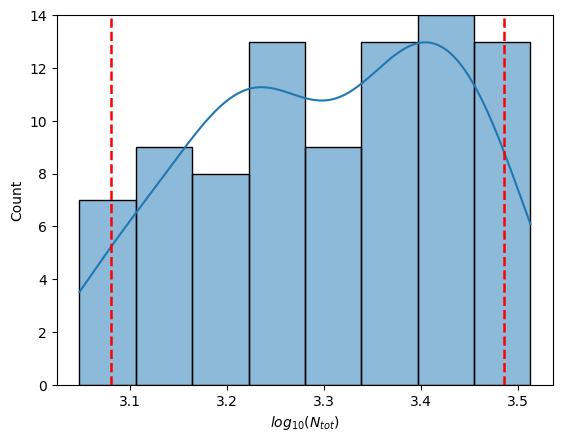

In [92]:
# Density to show 95% CI on N
import seaborn as sns

to_show = df[(df.variance > 0)].copy()
to_show = to_show[
    (to_show.slope > 2.1)
    & (to_show.slope < 2.2)
    & (to_show.log_center_to_center_nearest_neighbor_distance_mean > 1.6)
    & (to_show.log_center_to_center_nearest_neighbor_distance_mean < 1.8)
]

sns.histplot(
    x=to_show.log_n_craters_added_in_study_region,
    kde=True,
)
plt.ylim(0, 14)
plt.vlines(x=[3.08, 3.485], ymin=0, ymax=15, linestyles="dashed", color="red", linewidth=1.8)
plt.xlabel("$log_{10}(N_{tot})$")

Text(0.5, 0, '$N_{tot}$')

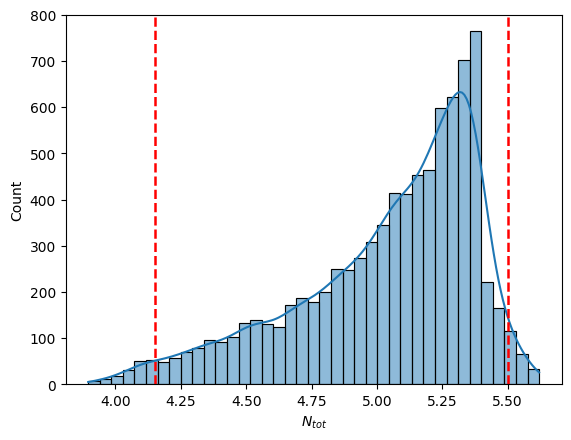

In [96]:
# Density to show 95% CI on N
import seaborn as sns

to_show = df[(df.variance > 0)].copy()
to_show = to_show[
    (to_show.slope > 2.1)
    & (to_show.slope < 2.2)
    & (to_show.log_center_to_center_nearest_neighbor_distance_mean > 1.2)
    & (to_show.log_center_to_center_nearest_neighbor_distance_mean < 1.4)
]

sns.histplot(
    x=to_show.log_n_craters_added_in_study_region,
    kde=True,
)
plt.ylim(0, 800)
plt.vlines(x=[4.15, 5.5], ymin=0, ymax=800, linestyles="dashed", color="red", linewidth=1.8)
plt.xlabel("$N_{tot}$")

In [100]:
np.log10(316226/14125)

1.3500091181253295

In [18]:
df["log_var"] = np.log10(df.variance)
to_show = df.sample(df.shape[0] // 10)
to_show = to_show[to_show.variance > 0]
fig = px.scatter_3d(
    to_show,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    z="slope",
    color="log_variance",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
)
fig.update_traces(marker={"size":3})
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



In [19]:
d = df[df.variance > 0]

d[d.test == 0].sort_values("crater_id").to_parquet(f"{base_path}/train_with_variance.parquet")
d[d.test == 1].sort_values("crater_id").to_parquet(f"{base_path}/test_with_variance.parquet")